In [1]:
# You will need to install iqm-benchmarks from the github repo to access all the mGST functions: https://github.com/iqm-finland/iqm-benchmarks
from mGST.low_level_jit import dK, objf
import shelve
import numpy as np

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from mGST.algorithm import gd
from mGST.low_level_jit import cost_function_jax

%load_ext autoreload
%autoreload 2

In [2]:
# Loading parameters
filename = "./Minimal_gradient/shelve_out"
my_shelf = shelve.open(filename)
for key in ["K", "E_new", "rho", "y", "J", "d", "r", "rK", "fixed_elements"]:
    print(key)
    globals()[key]=my_shelf[key]
my_shelf.close()

K
E_new
rho
y
J
d
r
rK
fixed_elements


In [3]:
J.shape
# Suggestion:
# Change J into a list of lists. -> so that the difference in length is not a problem
# See if JAX complains about it.

(100, 14)

In [4]:
print(d), print(r), print(fixed_elements)

3
4
[]


(None, None, None)

In [5]:
# Setting some additional_parameters
E = E_new
pdim = int(np.sqrt(r))
n = rK * pdim
Delta = np.zeros((d, n, pdim)).astype(np.complex128)
X = np.einsum("ijkl,ijnm -> iknlm", K, K.conj()).reshape((d, r, r))

In [6]:
print(objf(X, E, rho, J, y))

0.001976257299832181


In [17]:
dK_ = dK(X, K, E, rho, J, y, d, r, rK)

In [18]:
dK_.shape, dK_.dtype, type(dK_)

((3, 4, 2, 2), dtype('complex128'), numpy.ndarray)

# Try obtain the derivative but with JAX

In [11]:
a = jnp.array([1,1])
jnp.complex128(a)

Array([1.+0.j, 1.+0.j], dtype=complex128)

In [12]:
d = 3
r = 4

In [13]:
cost_function_jax(K, d, r, E, rho, J, y)

Array(0.00197626, dtype=float64)

**Result with single precision**: Array(0.00197626, dtype=float32)

In [14]:
grad_jax = jax.grad(fun=cost_function_jax, argnums=0)(K, d, r, E, rho, J, y)

In [15]:
grad_jax.shape, grad_jax.dtype

((3, 4, 2, 2), dtype('complex128'))

In [19]:
jnp.allclose(grad_jax/2, dK_)

Array(True, dtype=bool)

In [20]:
jnp.linalg.norm(grad_jax - dK_)

Array(0.06980057, dtype=float64)

In [21]:
K.dtype, E.dtype, rho.dtype, J.dtype, y.dtype

(dtype('complex128'),
 dtype('complex128'),
 dtype('complex128'),
 dtype('int32'),
 dtype('float64'))

In [22]:
grad_jax[0,0,:,:]/2

Array([[ 6.89530895e-06+1.41335293e-05j, -6.95757287e-07+2.63181640e-05j],
       [ 1.79551344e-05-1.89523399e-05j,  1.34852364e-05+4.34467736e-06j]],      dtype=complex128)

In [28]:
dK_[0,0,:,:]

array([[ 6.89530895e-06+1.41335293e-05j, -6.95757287e-07+2.63181640e-05j],
       [ 1.79551344e-05-1.89523399e-05j,  1.34852364e-05+4.34467736e-06j]])

## Conclusion up to now:

The gradients seem to match up to a factor of 2 and the conjugation. I will now check the results both of these return inside the algorithm.

### TODO:
* Once I verify they both give reasonable results, I can time both executions

# Gradient Descent

In [30]:
fixed_gates = np.array([(f"G%i" % i in fixed_elements) for i in range(d)])
fixed_gates

def get_x_from_k(k):
    return np.einsum("ijkl,ijnm -> iknlm", k, k.conj()).reshape((d, r, r))

K_gds = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA")

In [31]:
x_gds = get_x_from_k(k=K_gds)

print('Old f(x):', objf(X, E, rho, J, y))
print('New f(x):', objf(x_gds, E, rho, J, y))

Old f(x): 0.001976257299832181
New f(x): 0.0015298804063626525


In [32]:
K_gds_jax = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", use_jax=True)

Using JAX power


In [33]:
x_gds_jax = get_x_from_k(k=K_gds_jax)

print('Old f(x):', objf(X, E, rho, J, y))
print('New f(x):', objf(x_gds_jax, E, rho, J, y))

Old f(x): 0.001976257299832181
New f(x): 0.001529880401664766


In [34]:
# NOTE: we are able to obtain the same result up to numerical precision.
# However, this is without taking the conj() of the gradient, which is weird!
# Could the definition be taking already the conjugate into accoiunt? 
# (so that the conjugate of the gradient is actually the direction we want to follow)

# Timing: (after restarting to avoid cache) - Do not run again

In [34]:
# defining the numba function including the contraction of X:
def grad_numba(K, E, rho, J, y, d, r, rK):
    X = np.einsum("ijkl,ijnm -> iknlm", K, K.conj()).reshape((d, r, r))
    grad = dK(X, K, E, rho, J, y, d, r, rK)
    return grad

In [6]:
# lets time how long it takes to compute the gradients

# Without JIT
# First let's time the TN contraction:
%timeit grad_numba(K, E, rho, J, y, d, r, rK)

44.2 ms ± 741 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# lets time how long it takes to compute the gradients

# Without JIT
# First let's time the TN contraction:
%timeit dK(X, K, E, rho, J, y, d, r, rK)

43.8 ms ± 219 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# Without JIT
# Now let's time JAX:
%timeit jax.grad(fun=cost_function_jax, argnums=0)(K, d, r, E, rho, J, y)

534 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# With Numba cache and JIT
%timeit grad_numba(K, E, rho, J, y, d, r, rK)

5.25 ms ± 88.4 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# With JIT
%timeit jax.grad(fun=cost_function_jax, argnums=0)(K, d, r, E, rho, J, y)

275 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
275/5.25

52.38095238095238

In [ ]:
# 1. Change np -> jax.numpy: compute gradient.
# 2. Efficiency: whether we JIT or not. We can JIT the main cost function and see what's the best performance we can get with JAX.
# 3. Scaling: So far we have run only for single qubit. We can check for 2 and 3 qubits.
#   -> 2-qubit: ~500x100 tensors.

# Test that the gradient is correct

In [185]:
# lets construct the left hand side of the equation
f_k = lambda k: cost_function_jax(K=k, d=d, r=r, E=E, rho=rho, J=J, y=y)
def cost_alpha(alpha, k, gradient):
    "cost function f(x + alpha*gradient) as a function of alpha"
    k_alpha = k + 2 * alpha * gradient
    return f_k(k_alpha)

alphas = np.arange(-0.1, 0.1, 0.002)
function_value_jax = [cost_alpha(alpha, K, grad_jax) for alpha in alphas]

In [186]:
function_value_alpha_tn = [cost_alpha(alpha, K, dK_) for alpha in alphas]

In [187]:
# Now let's construct the linear approximation

def tensor_inner_product_euclidean(tensor:jnp.array):
    "Euclidean norm of a tensor of rank 4"
    return jnp.real(jnp.einsum("ijkl,ijkl", tensor, tensor.conj()))

def linear_approx(alpha, k0, gradient):
    "Linear approximation of cost_alpha around k"
    return f_k(k0) + alpha * tensor_inner_product_euclidean(gradient)

linear_approx_jax = [linear_approx(alpha, K, grad_jax) for alpha in alphas]

In [188]:
linear_approx_tn = [linear_approx(alpha, K, dK_) for alpha in alphas]

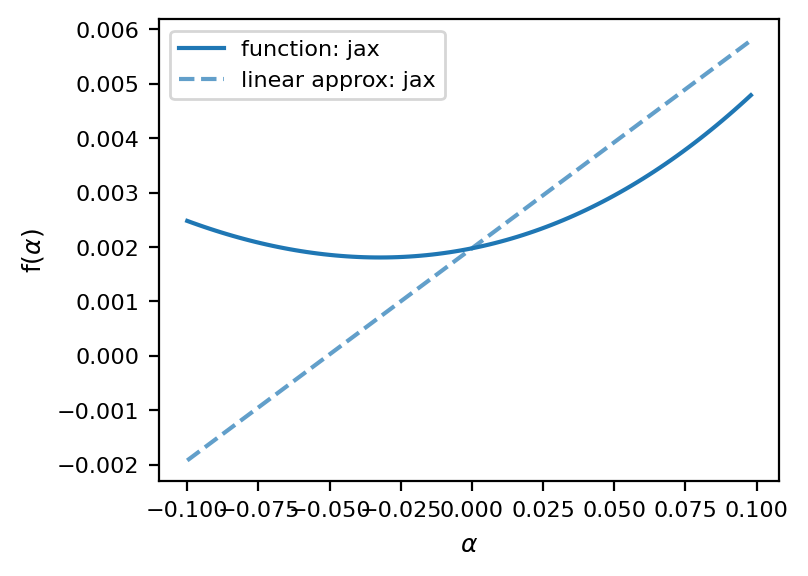

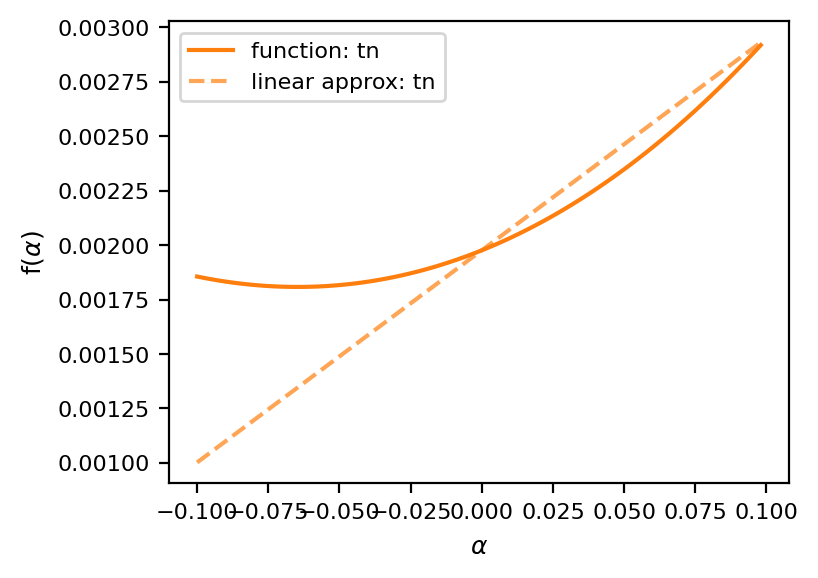

In [158]:

plt.figure(dpi=200, figsize=(4,3))
# Plot function and approximations with matching colors and different line styles
plt.plot(alphas, function_value_jax, color='C0', label='function: jax')           # Solid blue
plt.plot(alphas, linear_approx_jax, '--', color='C0', alpha=0.7, label='linear approx: jax')  # Dashed blue, transparent

plt.xlabel(r'$\alpha$')
plt.ylabel(r'f($\alpha$)')

plt.legend()

plt.figure(dpi=200, figsize=(4,3))

plt.plot(alphas, function_value_alpha_tn, color='C1', label='function: tn')       # Solid orange
plt.plot(alphas, linear_approx_tn, '--', color='C1', alpha=0.7, label='linear approx: tn')    # Dashed orange, transparent

plt.xlabel(r'$\alpha$')
plt.ylabel(r'f($\alpha$)')

plt.legend()

In [ ]:
# My idea to test what is going on:
# I should look at another real-valued function like Re(x.conj().T @ A @ x), whose gradient we know
# and then do the same procedure verifying that what we obtain from jax is 2*wirtinger derivative.
# Maybe I just need to multiply the derivative coming from his code? And then include the 2 in the lHS?

In [23]:
key = jax.random.PRNGKey (1)
key1 , key2 , key3 = jax.random.split(key , num=3) 

A = jax.random.normal(key1 , (3, 3), dtype=complex)
z = jax.random.normal(key2 , (3,), dtype=complex)


def f(z):
    return jnp.real(z.conj() @ A @ z)

f(z), jnp.real(A)*z*z.conj()

(Array(-1.98963185, dtype=float64),
 Array([[-0.38915185+0.00000000e+00j,  0.09239622+0.00000000e+00j,
          0.04377127+0.00000000e+00j],
        [-0.28363886+0.00000000e+00j,  0.03990889+1.73472348e-18j,
         -0.15353217+0.00000000e+00j],
        [ 0.95746197+0.00000000e+00j, -0.07903597+0.00000000e+00j,
         -0.17628233+0.00000000e+00j]], dtype=complex128))

In [24]:
def df_dz_conj(z):
    return z.T @ A.T

def df_dz(z):
    return z.conj().T@A

def grad_analytical(z):
    return (A.conj().T @ z) + (A @ z)

wirtinger_conjugate = df_dz_conj(z)
wirtinger = df_dz(z)
wirtinger_conjugate, wirtinger

(Array([ 0.94996481-0.16077747j, -0.85476061-0.34907628j,
        -0.48227655+1.33139114j], dtype=complex128),
 Array([-0.48989732+1.64139669j, -1.10006515-0.15938573j,
        -0.71109612-0.29168526j], dtype=complex128))

In [25]:
grad_z_anal = grad_analytical(z)
grad_z_anal

Array([ 0.46006749-1.80217416j, -1.95482576-0.18969055j,
       -1.19337267+1.6230764j ], dtype=complex128)

In [26]:
grad_f = jax.grad(f)
grad_z = grad_f(z)
grad_z

Array([ 0.46006749+1.80217416j, -1.95482576+0.18969055j,
       -1.19337267-1.6230764j ], dtype=complex128)

In [27]:
jnp.allclose(wirtinger_conjugate.T + wirtinger.conj().T, grad_z.conj())

Array(True, dtype=bool)

In [28]:
2*jnp.real(wirtinger_conjugate)

Array([ 1.89992961, -1.70952121, -0.96455309], dtype=float64)

In [29]:
jnp.allclose(2*jnp.real(wirtinger_conjugate), grad_z)

Array(False, dtype=bool)

In [30]:
jnp.allclose(2*jnp.real(wirtinger.T), grad_z)

Array(False, dtype=bool)

In [31]:
jnp.allclose(grad_z.conj(), grad_z_anal)

Array(True, dtype=bool)

In [32]:
wirtinger_conjugate + wirtinger

Array([ 0.46006749+1.48061922j, -1.95482576-0.50846201j,
       -1.19337267+1.03970588j], dtype=complex128)

In [33]:
def df_dz_2(z):
    return 0.5*z.conj().T @ (A + A.conj().T)

def df_dz_2_conj_2(z):
    return 0.5*z.T @ (A.conj() + A.T)

wirtinger_conjugate_2 = df_dz_2_conj_2(z)
wirtinger_2 = df_dz_2(z)
wirtinger_conjugate_2, wirtinger_2

(Array([ 0.23003374-0.90108708j, -0.97741288-0.09484527j,
        -0.59668633+0.8115382j ], dtype=complex128),
 Array([ 0.23003374+0.90108708j, -0.97741288+0.09484527j,
        -0.59668633-0.8115382j ], dtype=complex128))

In [36]:
grad_analytical_2 = wirtinger_2.conj() + wirtinger_conjugate_2
jnp.allclose(grad_analytical_2, grad_z.conj())

Array(True, dtype=bool)

In [35]:
grad_jax_2 = 2 * wirtinger_2
jnp.allclose(grad_jax_2, grad_z)

Array(True, dtype=bool)

In [37]:
jnp.allclose(2 * wirtinger_conjugate_2, grad_analytical_2)

Array(True, dtype=bool)

In [38]:
jnp.allclose(grad_z.conj(), 2 * wirtinger_conjugate_2)

Array(True, dtype=bool)

In [28]:
# Search: what is the relation between wirtinger derivatives for real functions.
# Conclusions so far:
# 1. The differential df is not the same as the gradient!
# 2. My second attempt work perfectly! I derived the wirtinger derivatives from the Re(v@Av) expressions and used the relations:
# grad_jax = 2 @ df/dz or grad = 2 @ df/dz*, which also uses df/dz = (df/dz*)* because here f is real valued (unlike in the example from the paper)!
#  This satisfied all the relations I wanted! Including: grad f = VJP at fbar equal 1 = (df/dz)* + (df/dz*)


# New tests: using $df/dz$ vs $df/dz^*$ in gradient descent!

start: 08.01.25

update: moved to the gst_opt_testbed.ipynb

goal: Currently the code from Raphael uses the df/dz instead of df/dz*, even thought the latter is the correct one (one relates to the other by conjugation)

In [9]:
# First let's run the optimization normally with the df/dz:

fixed_gates = np.array([(f"G%i" % i in []) for i in range(d)])
fixed_gates

def get_x_from_k(k):
    return np.einsum("ijkl,ijnm -> iknlm", k, k.conj()).reshape((d, r, r))

K_gds = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA")


print('Un-optimized f(x):', objf(X, E, rho, J, y))
print('Optimized f(x):', objf(x_gds, E, rho, J, y))

Un-optimized f(x): 0.001976257299832181
Optimized f(x): 0.0015298804063626462


In [10]:
fixed_gates

array([False, False, False])

In [37]:
# Now let's check with the conjugate:
K_gds = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", conjugate=True)

x_gds = get_x_from_k(k=K_gds)

print('Un-optimized f(x):', objf(X, E, rho, J, y))
print('Optimized f(x):', objf(x_gds, E, rho, J, y))

Un-optimized f(x): 0.001976257299832181
Optimized f(x): 0.0018796878033150999


In [38]:
# Now let's check with the conjugate:
K_gds = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", conjugate=False, use_jax=True)

x_gds = get_x_from_k(k=K_gds)

print('Un-optimized f(x):', objf(X, E, rho, J, y))
print('Optimized f(x):', objf(x_gds, E, rho, J, y))

Using JAX power
Un-optimized f(x): 0.001976257299832181
Optimized f(x): 0.001529880401664766


In [39]:
# Now let's check with the conjugate:
K_gds = gd(K, E_new, rho, y, J, d, r, rK, fixed_gates=fixed_gates, ls="COBYLA", conjugate=True, use_jax=True)

x_gds = get_x_from_k(k=K_gds)

print('Un-optimized f(x):', objf(X, E, rho, J, y))
print('Optimized f(x):', objf(x_gds, E, rho, J, y))

Using JAX power
Un-optimized f(x): 0.001976257299832181
Optimized f(x): 0.001879688023486612
